# HW02 – 聲量分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import numpy as np
import re

# font
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


## 定義品牌

In [2]:
from typing import TypedDict


class BrandMatcher(TypedDict):
    brand: str
    matcher: re.Pattern


In [3]:
brands_matchers: list[BrandMatcher] = [
    {
        "brand": "Nike",
        "matcher": re.compile(r"Nike|耐吉|耐克", re.IGNORECASE)
    },
    {
        "brand": "Shock Absorber",
        "matcher": re.compile(r"Shock(?:\s*)Absorber|Shock_Absorber", re.IGNORECASE)
    },
    {
        "brand": "Adidas",
        "matcher": re.compile(r"Adidas|愛迪達", re.IGNORECASE)
    },
    {
        "brand": "UA",
        "matcher": re.compile(r"UA|Under Armour", re.IGNORECASE)
    },
    {
        "brand": "Triumph",
        "matcher": re.compile(r"Triumph|黛安芬", re.IGNORECASE)
    },
    {
        "brand": "Mollifix",
        "matcher": re.compile(r"Mollifix", re.IGNORECASE)
    },
    {
        "brand": "Uniqio",
        "matcher": re.compile(r"Uniqio", re.IGNORECASE)
    },
    {
        "brand": "Calvin Klein",
        "matcher": re.compile(r"Calvin(.*)Klein|CK|Calvin_Klein", re.IGNORECASE)
    }
]

## Import file

In [4]:
df = pd.read_csv('PTT_運動內衣500.csv')

移除「公告」分類的項目

In [5]:
df = df[df['分類'] != '公告']

## 處理內文

讀取 stopwords list

In [6]:
# stopwords and remove_words cleaning
import json


with open("../assets/stopwords.txt", "r") as f:
    stopwords = f.read().splitlines()

with open("../assets/remove_words.json", "r") as f:
    stopwords.extend(json.load(f))

In [7]:
df = df.replace(stopwords, '')

In [10]:
from ast import literal_eval
from typing import Any

# 清理文字中的 stopwords 和垃圾文字
def clean_stopwords(x: Any) -> str:
    x = str(x)

    # 移除 html tags
    x = re.sub(r'<[^>]*>', '', x)

    # 移除網址
    x = re.sub(r'https?://[^\s]+', '', x)

    # 移除非必要前綴
    x = re.sub(r'(新聞連結|原文連結|原文內容)[：:]', '', x)
    
    # 移除空白
    x = re.sub(r'\s*', '', x)

    # 移除停用詞
    for word in stopwords:
        x = x.replace(word, '')

    return x

# 解析留言並擷取正確內容
def comments_content_to_one_line(x: Any) -> str:
    x = str(x)

    # 發現內容是 JSON，直接解析
    try:
        evaled_content = literal_eval(x)
        
        if not isinstance(evaled_content, list):
            raise ValueError("Invalid JSON string")
        
        content = " ".join([item.get('content', '') for item in evaled_content])
        return clean_stopwords(content)
    except Exception as e:
        # 無效資料，回傳空值
        print(f"無效資料 {x}: {e}")
        return ""


df['內文_cleaned'] = df['內文'].apply(clean_stopwords)
df['留言_cleaned'] = df['留言'].apply(comments_content_to_one_line)

df['所有文'] = (df['內文_cleaned'] + df['留言_cleaned']).str.strip()

無效資料  '縱': Invalid JSON string
無效資料 nan: malformed node or string on line 1: <ast.Name object at 0x11137ec50>
無效資料 nan: malformed node or string on line 1: <ast.Name object at 0x1203ed450>
無效資料 nan: malformed node or string on line 1: <ast.Name object at 0x124fbca90>


統一品牌字詞

In [13]:
def unify_brand_words(x: str) -> str:
    for brand_matcher in brands_matchers:
        matcher = brand_matcher['matcher']
        x = matcher.sub(brand_matcher['brand'], x)

    return x

df['所有文'] = df['所有文'].apply(unify_brand_words)

## 畫圖


In [14]:
counts: dict[str, int] = {brand["brand"]: 0 for brand in brands_matchers}

for content in df["所有文"]:
    for brand in brands_matchers:
        counts[brand["brand"]] += content.count(brand["brand"])

counts


{'Nike': 13,
 'Shock Absorber': 0,
 'Adidas': 8,
 'UA': 17,
 'Triumph': 0,
 'Mollifix': 0,
 'Uniqio': 0,
 'Calvin Klein': 31}

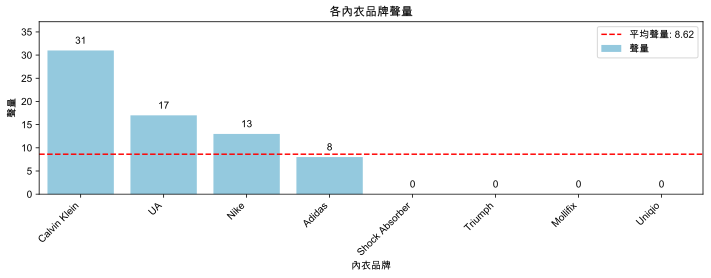

In [17]:
# Create figure and axis with specific size
plt.figure(figsize=(10, 4))

# Order brands by counts
brands = sorted(counts, key=lambda x: counts[x], reverse=True)
values = [counts[brand] for brand in brands]

# Add padding to plot borders
plt.margins(x=0.1, y=0.2)

# Plot bars
sns.barplot(x=brands, y=values, color='skyblue', label="聲量")
for i, v in enumerate(values):
    plt.text(i, v+2, str(v), ha='center', va='center')

# Calculate and plot mean line
mean_value = float(np.mean(values))
plt.axhline(y=mean_value, color='red', linestyle='--', label=f'平均聲量: {mean_value:.2f}')

# Customize the plot
plt.title('各內衣品牌聲量')
plt.xlabel('內衣品牌')
plt.ylabel('聲量')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()